In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/major/EpilepticInformation.csv')

In [ ]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
data["dependent_var"] = data.y == 1
data["dependent_var"] = data["dependent_var"].astype(int)
data.pop('y')
data.drop(data.columns[0], axis=1, inplace=True)

In [ ]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,dependent_var
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [ ]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return sum(y_actual) / len(y_actual)


print(
    "prevalence of the positive class: %.3f"
    % calc_prevalence(data["dependent_var"].values)
)


prevalence of the positive class: 0.200


In [ ]:
print("# of Columns:", len(data.columns))

# of Columns: 179


Feature Engineering

In [ ]:
collist = data.columns.tolist()
cols_input = collist[0:178]
data_data = data[cols_input + ["dependent_var"]]

In [ ]:
# check for duplicated columns in cols_input
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "you have duplicated columns in cols_input"

set()


In [ ]:
# check for duplicated columns in df_data
cols_df_data = list(data_data.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0,'you have duplicated columns in df_data'


set()


In [ ]:
# check the size of df_data makes sense
assert (len(cols_input) + 1) == len(data_data.columns), "issue with dimensions of df_data or cols_input"


Building Training/Validation/Test Samples

In [ ]:
df_data = data_data.sample(n=len(data_data))
df_data = data_data.reset_index(drop=True)

In [ ]:
df_valid_test = df_data.sample(frac=0.3)
print("Validation/Test Split Size: %.1f" % (len(df_valid_test) / len(df_data)))

df_test = df_valid_test.sample(frac=0.5)
df_valid = df_valid_test.drop(df_test.index)

df_train_all = df_data.drop(df_valid_test.index)


Validation/Test Split Size: 0.3


In [ ]:
# check the prevalence of each
print("Test prevalence(n = %d):%.3f" % (len(df_test), calc_prevalence(df_test.dependent_var.values)))
print("Valid prevalence(n = %d):%.3f" % (len(df_valid), calc_prevalence(df_valid.dependent_var.values)))
print("Train all prevalence(n = %d):%.3f" % (len(df_train_all), calc_prevalence(df_train_all.dependent_var.values)))


Test prevalence(n = 1725):0.198
Valid prevalence(n = 1725):0.193
Train all prevalence(n = 8050):0.202


In [ ]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 11500)


In [ ]:
rows_pos = df_train_all.dependent_var == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

n = np.min([len(df_train_pos), len(df_train_neg)])

df_train = pd.concat([df_train_pos.sample(n=n, random_state=69), df_train_neg.sample(n=n, random_state=69)], axis=0, ignore_index=True)

df_train = df_train.sample(n=len(df_train), random_state=69).reset_index(drop=True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.dependent_var.values)))



Train balanced prevalence(n = 3250):0.500


In [ ]:
#Save all 4 dataframes to csv and the cols_input
df_train_all.to_csv('/content/drive/MyDrive/major/df_train_all.csv',index=False)
df_train.to_csv('/content/drive/MyDrive/major/df_train.csv',index=False)
df_valid.to_csv('/content/drive/MyDrive/major/df_valid.csv',index=False)
df_test.to_csv('/content/drive/MyDrive/major/df_test.csv',index=False)

In [ ]:
pickle.dump(cols_input, open('/content/drive/MyDrive/major/cols_input.sav', 'wb'))

In [ ]:
# a function to fill missing values with mean of the column if needed
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [ ]:
# create the X and y matrices
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['dependent_var'].values
y_valid = df_valid['dependent_var'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)


scaler  = StandardScaler()
scaler.fit(X_train_all)

scalerfile = '/content/drive/MyDrive/major/scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)


Training All shapes: (8050, 178)
Training shapes: (3250, 178) (3250,)
Validation shapes: (1725, 178) (1725,)


Model Selection

In [ ]:

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 


In [ ]:
thresh = 0.5

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Model Selection: baseline models**

K nearest neighbors (KNN)

In [ ]:
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.991
accuracy:0.622
recall:0.244
precision:0.997
specificity:0.999
prevalence:0.500
 
Validation:
AUC:0.967
accuracy:0.856
recall:0.258
precision:0.989
specificity:0.999
prevalence:0.193
 


Logistic Regression

In [ ]:
lr = LogisticRegression(random_state = 69)
lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.634
accuracy:0.654
recall:0.542
precision:0.698
specificity:0.766
prevalence:0.500
 
Validation:
AUC:0.531
accuracy:0.706
recall:0.483
precision:0.325
specificity:0.759
prevalence:0.193
 


Stochastic Gradient Descent

In [ ]:
SGDC = SGDClassifier(loss = 'log',alpha = 0.1)
SGDC.fit(X_train_tf, y_train)

y_train_preds = SGDC.predict_proba(X_train_tf)[:,1]
y_valid_preds = SGDC.predict_proba(X_valid_tf)[:,1]

print('SGDC')
print('Training:')
SGDC_train_auc, SGDC_train_accuracy, SGDC_train_recall, \
    SGDC_train_precision, SGDC_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
SGDC_valid_auc, SGDC_valid_accuracy, SGDC_valid_recall, \
    SGDC_valid_precision, SGDC_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


SGDC
Training:
AUC:0.583
accuracy:0.621
recall:0.540
precision:0.645
specificity:0.702
prevalence:0.500
 
Validation:
AUC:0.526
accuracy:0.672
recall:0.471
precision:0.288
specificity:0.721
prevalence:0.193
 


Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, \
nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, \
nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.983
accuracy:0.932
recall:0.895
precision:0.965
specificity:0.968
prevalence:0.500
 
Validation:
AUC:0.985
accuracy:0.959
recall:0.889
precision:0.897
specificity:0.976
prevalence:0.193
 


Decision Trees

In [ ]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 69)
tree.fit(X_train_tf, y_train)

y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, \
tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, \
tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.983
accuracy:0.979
recall:0.961
precision:0.997
specificity:0.998
prevalence:0.500
 
Validation:
AUC:0.852
accuracy:0.901
recall:0.859
precision:0.698
specificity:0.911
prevalence:0.193
 


Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth = 6, random_state = 69)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, \
rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, \
rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


Random Forest
Training:
AUC:0.997
accuracy:0.967
recall:0.945
precision:0.988
specificity:0.989
prevalence:0.500
 
Validation:
AUC:0.993
accuracy:0.958
recall:0.913
precision:0.874
specificity:0.968
prevalence:0.193
 


Gradient Boosting 

In [ ]:
gbc = GradientBoostingClassifier( \
    n_estimators=100, learning_rate=1.0, max_depth=3, random_state=69)
gbc.fit(X_train_tf, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, \
gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, \
gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.993
accuracy:0.960
recall:0.946
precision:0.861
specificity:0.963
prevalence:0.193
 


Extremely Random Trees

In [ ]:
etc = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=1.0,
                           min_samples_leaf=3, min_samples_split=20, n_estimators=100)
etc.fit(X_train_tf, y_train)

y_train_preds = etc.predict_proba(X_train_tf)[:, 1]
y_valid_preds = etc.predict_proba(X_valid_tf)[:, 1]

print('Extra Trees Classifier')
print('Training:')
etc_train_auc, etc_train_accuracy, etc_train_recall, etc_train_precision, \
etc_train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
etc_valid_auc, etc_valid_accuracy, etc_valid_recall, etc_valid_precision, \
etc_valid_specificity = print_report(y_valid, y_valid_preds, thresh)


Extra Trees Classifier
Training:
AUC:1.000
accuracy:0.997
recall:0.998
precision:0.996
specificity:0.996
prevalence:0.500
 
Validation:
AUC:0.995
accuracy:0.963
recall:0.976
precision:0.853
specificity:0.960
prevalence:0.193
 


XGBoost Classifier

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train_tf, y_train)

y_train_preds = xgbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = xgbc.predict_proba(X_valid_tf)[:,1]

print('Xtreme Gradient Boosting Classifier')
print('Training:')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, \
xgbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, \
xgbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


Xtreme Gradient Boosting Classifier
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
specificity:1.000
prevalence:0.500
 
Validation:
AUC:0.995
accuracy:0.965
recall:0.964
precision:0.870
specificity:0.966
prevalence:0.193
 


Analyze results baseline models

In [ ]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB','XGBC','XGBC','ETC','ETC'], \
                           'data_set':['train','valid']*9, \
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,SGDC_train_auc,SGDC_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,xgbc_train_auc,xgbc_valid_auc,etc_train_auc,etc_valid_auc], \
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,SGDC_train_accuracy,SGDC_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,xgbc_train_accuracy,xgbc_valid_accuracy,etc_train_accuracy,etc_valid_accuracy], \
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,SGDC_train_recall,SGDC_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,xgbc_train_recall,xgbc_valid_recall,etc_train_recall,etc_valid_recall], \
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,SGDC_train_precision,SGDC_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,xgbc_train_precision,xgbc_valid_precision,etc_train_precision,etc_valid_precision], \
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,SGDC_train_specificity,SGDC_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity,xgbc_train_specificity,xgbc_valid_specificity,etc_train_specificity,etc_valid_specificity]})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

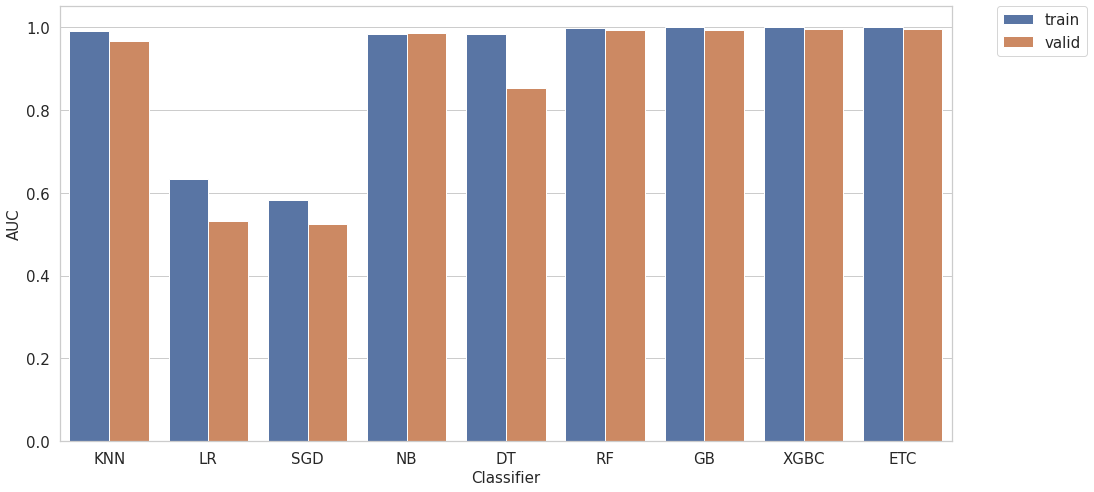

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
ax = sns.barplot(x = 'classifier', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classifier', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

#Separate legend from graph
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)


In [ ]:
# this is a quick way to tune one parameter of your model while holding everything else constant.
import time

my_params =  np.arange(0.05, 1.01, 0.05) # fill this in your list of parameters

# initialize arrays for storing the results
train_metrics = np.zeros(len(my_params))
valid_metrics = np.zeros(len(my_params))

# train a model for each param in a list
t1 = time.time()
for jj in range(len(my_params)):
    my_param = my_params[jj]
    
    # fit model
    model = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=my_param, min_samples_leaf=3, min_samples_split=20, n_estimators=100)
    model.fit(X_train_tf, y_train)
    # get predictions
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    metric_train = roc_auc_score(y_train, y_train_preds) # fill this in
    metric_valid = roc_auc_score(y_valid, y_valid_preds) # fill this in

    # save aucs
    train_metrics[jj] = metric_train
    valid_metrics[jj] = metric_valid
    
    # print the time
    t2 = time.time()
    print(my_param, t2-t1)
    t1 = time.time()

0.05 0.5835788249969482
0.1 0.833392858505249
0.15000000000000002 1.0086007118225098
0.2 1.188619613647461
0.25 1.3677823543548584
0.3 1.6200575828552246
0.35000000000000003 1.7717492580413818
0.4 1.9396109580993652
0.45 2.1095151901245117
0.5 2.319485902786255
0.55 2.47365140914917
0.6000000000000001 2.6501195430755615
0.6500000000000001 2.8232882022857666
0.7000000000000001 3.0807383060455322
0.7500000000000001 3.2051641941070557
0.8 3.431321620941162
0.8500000000000001 3.5985758304595947
0.9000000000000001 3.772371530532837
0.9500000000000001 3.9843668937683105
1.0 4.1067187786102295


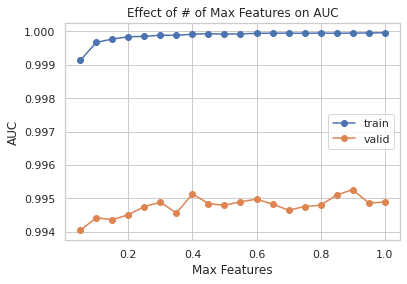

In [ ]:
import matplotlib.pyplot as plt

plt.plot(my_params, train_metrics,'o-',label = 'train')
plt.plot(my_params, valid_metrics,'o-',label = 'valid')

plt.xlabel('Max Features') # fill this in
plt.ylabel('AUC')# fill this in
plt.title('Effect of # of Max Features on AUC') # fill this in
plt.legend()
plt.show()


Learning Curves

We plot learning curves for our best performing model.


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    plt.figure(figsize=(16, 8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.


title = 'AUC Learning Curve for ExtraTrees'                                      
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=1.0, min_samples_leaf=3, min_samples_split=20, n_estimators=100)                                    
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)


plt.show()


My model has a low variance and a low bias

Feature Importance

In [ ]:
feature_importances = pd.DataFrame(etc.feature_importances_, \
                                   index = cols_input, \
                                    columns=['importance']).sort_values('importance', \
                                                                        ascending=False)


In [ ]:
feature_importances.head()

In [ ]:
pos_features = feature_importances.loc[feature_importances.importance > 0]

num = np.min([50, len(pos_features)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = pos_features.iloc[:num].values.ravel()[::-1]
feature_labels = list(pos_features.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - ExtraTrees Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()


In [ ]:
ax = xgb.plot_importance(xgbc)
fig = ax.figure
fig.set_size_inches(10, 35)
plt.savefig('xgbcf.png')


In [ ]:
! pip install shap

In [ ]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X = df_train.drop(columns=['dependent_var'])
model = xgbc

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")
plt.savefig('shap.png')

In [ ]:
feature_importances = pd.DataFrame(xgbc.feature_importances_, \
                                   index = cols_input, \
                                    columns=['importance']).sort_values('importance', \
                                                                        ascending=False) \

In [ ]:
pos_features = feature_importances.loc[feature_importances.importance > 0]

num = np.min([50, len(pos_features)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = pos_features.iloc[:num].values.ravel()[::-1]
feature_labels = list(pos_features.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - XGBoost Classifier')
plt.yticks(ylocs, feature_labels)
plt.savefig('xgbc.png')
plt.show()

Ultimately, all of the features should be equally important, since they are all EEG measures. Theoretically, there isn't any single one millisecond that is more important or predictive than any other millisecond in terms of determining whether a patient is having an epileptic seizure or not.

Hyperparameter tuning

In [ ]:
! pip install dask distributed --upgrade

In [ ]:

!pip install dask-ml


In [ ]:
!pip install tpot

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:

from tpot import TPOTClassifier
import numpy as np
tpot_config = {         \
    'xgboost.XGBClassifier': {      \
        'n_estimators': [100],      \
        'max_depth': range(1, 11),  \
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],       \
        'subsample': np.arange(0.05, 1.01, 0.05),           \
        'min_child_weight': range(1, 21),                   \
        'nthread': [1]                                      \
    },                                                      \
    'sklearn.ensemble.ExtraTreesClassifier': {              \
        'n_estimators': [100],                              \
        'criterion': ["gini", "entropy"],                   \
        'max_features': np.arange(0.05, 1.01, 0.05),        \
        'min_samples_split': range(2, 21),                  \
        'min_samples_leaf': range(1, 21),                   \
        'bootstrap': [True, False]                          \
    }

}



In [ ]:
pipeline_optimizer = TPOTClassifier(verbosity=2, periodic_checkpoint_folder='tpot', generations=20, population_size=50, use_dask=True,scoring='roc_auc', config_dict=tpot_config, n_jobs=-1)
pipeline_optimizer.fit(X_train_tf, y_train)
print(pipeline_optimizer.score(X_valid, y_valid))
pipeline_optimizer.export('/content/drive/MyDrive/major/tpot_exported_pipeline.py')

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [ ]:
best_model = make_pipeline(                                                                                                 \
    make_union(                                                                                                             \
        FunctionTransformer(copy),                                                                                          \
        make_union(                                                                                                         \
            make_union(                                                                                                     \
                FunctionTransformer(copy),                                                                                  \
                make_union(                                                                                                 \
                    FunctionTransformer(copy),                                                                              \
                    make_union(                                                                                             \
                        StackingEstimator(estimator=make_pipeline(                                                          \
                            make_union(                                                                                     \
                                FunctionTransformer(copy),                                                                  \
                                FunctionTransformer(copy)                                                                   \
                            ),                                                                                              \
                            ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.1,                    \
                                                 min_samples_leaf=10, min_samples_split=10, n_estimators=100)               \
                        )),                                                                                                 \
                        FunctionTransformer(copy)                                                                           \
                    )                                                                                                       \
                )                                                                                                           \
            ),                                                                                                              \
            FunctionTransformer(copy)                                                                                       \
        )                                                                                                                   \
    ),                                                                                                                      \
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.05,                                              \
                         min_samples_leaf=2, min_samples_split=4, n_estimators=100)                                         \
)       

best_model.fit(X_train_tf, y_train)

y_train_preds = best_model.predict_proba(X_train_tf)[:, 1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:, 1]

print('ExtraTrees Classifier')
print('Training:')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(
    y_train, y_train_preds, thresh)
print('Validation:')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh)

Best model save

In [ ]:
pickle.dump(best_model, open('/content/drive/MyDrive/major/best_classifier.pkl', 'wb'),protocol = 4)


Model Evaluation

In [ ]:
# load the model, columns, and scaler
best_model = pickle.load(open('best_classifier.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
scaler = pickle.load(open('scaler.sav', 'rb'))

# load the data
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')
df_test= pd.read_csv('df_test.csv')

# create X and y matrices
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values
y_test = df_test['OUTPUT_LABEL'].values

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)


In [ ]:
#Calculate prediction probabilities
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [ ]:
#Performance evaluation
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

In [ ]:
#Roc Curve

from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()